# Cars4U Project

## Objective

__Cars4U__ is a budding tech start-up that aims to find footholds in the growing used cars market in India.<br/>
The aim for this project is 
* _Come up with a pricing model that can effectively predict the price of used cars._ 

We will be analyzing 2018-19 old cars sales data

## Data Description
The data contains the different attributes of used cars sold in different locations. The detailed data dictionary is given below.

### Data Dictionary
* S.No.: Serial number
* Name: Name of the car which includes brand name and model name
* Location: Location in which the car is being sold or is available for purchase (cities)
* Year: Manufacturing year of the car
* Kilometers_driven: The total kilometers driven in the car by the previous owner(s) in km
* Fuel_Type: The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
* Transmission: The type of transmission used by the car (Automatic/Manual)
* Owner: Type of ownership
* Mileage: The standard mileage offered by the car company in kmpl or km/kg
* Engine: The displacement volume of the engine in CC
* Power: The maximum power of the engine in bhp
* Seats: The number of seats in the car
* New_Price: The price of a new car of the same model in INR Lakhs (1 Lakh INR = 100,000 INR)
* Price: The price of the used car in INR Lakhs

In [1]:
# Course: Supervised Learning: Regression
# Project: Cars4U Project 
# Student: Sameer Girolkar
# Date: Oct 10, 2021

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to help preprocessing the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<IPython.core.display.Javascript object>

In [4]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
# Removes the limit from the number of displayed columns and rows.
# This is so I can see the entire dataframe when I print it
pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 200)

<IPython.core.display.Javascript object>

## Some useful functions

In [6]:
# function to plot histogram and barplot together
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")


# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


def box_plot_by_cat(data, category_col, y, n=None):
    count = data[category_col].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    sns.boxplot(
        x=category_col,
        y=y,
        data=data,
        order=data[category_col].value_counts().index[:n].sort_values(),
    )
    plt.xticks(rotation=90)
    plt.show()


# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

## Let's take a look at the Data

In [7]:
# loading the dataset
df = pd.read_csv("used_cars_data.csv")

<IPython.core.display.Javascript object>

In [8]:
# Shape of the data
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns.")

Data has 7253 rows and 14 columns.


<IPython.core.display.Javascript object>

In [9]:
# basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7078 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


<IPython.core.display.Javascript object>

### Observations
1. Some rows are missing the Price
2. Engine, Mileage & Power should be numeric columns but are treated as object
3. Seats are float
4. Most of the rows do not have New_Price. We may decide to drop this column after further analysis.
5. Year is treated as int64. We may have to convert this to string.

In [10]:
# Price being the target, rows without price are of no use to the analysis, so drop those
df.dropna(subset=["Price"], inplace=True)

<IPython.core.display.Javascript object>

In [11]:
# Sample of the data
df.sample(10)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
806,806,Ford Endeavour 3.2 Titanium AT 4X4,Coimbatore,2017,59636,Diesel,Automatic,First,10.91 kmpl,3198 CC,197 bhp,7.0,NaN,29.20
68,68,Maruti Ertiga SHVS VDI,Pune,2016,63000,Diesel,Manual,First,24.52 kmpl,1248 CC,88.5 bhp,7.0,NaN,8.15
1496,1496,Jaguar XJ 3.0L Portfolio LWB,Kochi,2016,17652,Diesel,Automatic,First,12.9 kmpl,2993 CC,270.88 bhp,5.0,NaN,58.73
957,957,Mercedes-Benz New C-Class C 220d Avantgarde Ed...,Pune,2015,50000,Diesel,Automatic,First,19.27 kmpl,2143 CC,167.62 bhp,5.0,NaN,30.00
1516,1516,Toyota Fortuner 4x4 MT,Hyderabad,2018,39927,Diesel,Manual,First,12.55 kmpl,2982 CC,168.5 bhp,7.0,NaN,32.10
2255,2255,Maruti Alto 800 2016-2019 LXI,Ahmedabad,2016,60000,Petrol,Manual,First,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN,2.65
298,298,Toyota Innova Crysta 2.4 ZX MT,Chennai,2016,48000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.4 Lakh,20.25
2072,2072,Audi A6 2.7 TDI,Mumbai,2009,30000,Diesel,Automatic,First,12.4 kmpl,2698 CC,179.5 bhp,5.0,NaN,8.95
517,517,Toyota Etios G,Coimbatore,2013,27075,Petrol,Manual,First,17.6 kmpl,1496 CC,88.73 bhp,5.0,NaN,4.95
5134,5134,Honda Brio S Option MT,Mumbai,2012,39566,Petrol,Manual,Second,18.4 kmpl,1198 CC,86.8 bhp,5.0,NaN,2.75


<IPython.core.display.Javascript object>

In [12]:
# drop s.No - it does not add any value
df.drop("S.No.", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [13]:
# Ensure the Name column uses consistent Case
df["Name"] = df["Name"].str.title()

# No of seats cannot be float - conver to int
df["Seats"] = df["Seats"].fillna(0).astype("int64")
df["Seats"] = df["Seats"].replace(0, np.nan)


# convert Mileage, Engine, Power columns to number
def str_to_num(val):
    # split the string by space. retunr the first index as a float
    if isinstance(val, str):
        return float(val.split()[0])
    else:
        return np.nan


for col in ["Mileage", "Engine", "Power"]:
    df[col] = df[col].map(str_to_num)

<IPython.core.display.Javascript object>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5976 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 658.3+ KB


<IPython.core.display.Javascript object>

In [15]:
# Lets look at the basic statastics of the data
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6017.000000,5983.000000,5876.000000,5976.000000,6019.000000
mean,2013.358199,5.873838e+04,18.134961,1621.276450,113.253050,5.279618,9.479468
std,3.269742,9.126884e+04,4.582289,601.355233,53.874957,0.806019,11.187917
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,2.000000,0.440000
25%,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


<IPython.core.display.Javascript object>

In [16]:
df.describe(include="object")

,Name,Location,Fuel_Type,Transmission,Owner_Type,New_Price
count,6019,6019,6019,6019,6019,824
unique,1852,11,5,2,4,540
top,Maruti Swift Dzire Vdi,Mumbai,Diesel,Manual,First,63.71 Lakh
freq,50,790,3205,4299,4929,6


<IPython.core.display.Javascript object>

### Observations
1. Most of the data looks Right skewed except for the Mileage 
2. Mileage column has a min value of 0. This looks wrong and will need to be addressed.
3. Mileage, Engine and Power columns have some missing values
3. Except for Name and New_Price, replacing other object columns with dummies will be helpful

In [17]:
# Lets replace mileage values of 0 with np.nan
df["Mileage"] = df["Mileage"].replace(0, np.nan)

<IPython.core.display.Javascript object>

In [18]:
# lets fill in the missing values for the "Mileage", "Engine", "Power" columns
# for this we will use the median value of the column for the same Model
def col_median_by_name(col, name):
    name_df = df[df["Name"] == name]
    return name_df[col].dropna().median()


for col in ["Mileage", "Engine", "Power", "Seats"]:
    df[col].fillna(col_median_by_name(col, df.Name), inplace=True)


<IPython.core.display.Javascript object>

## Univariate and Bivariate Analyses
Lets now take a look at the details of each columns and any correlations if observed.

### What about New_Price? 
Before moving any further with analysis lets check if the Largely Missing New_Price variable really has any effect on Price.

In [19]:
def new_price_to_number(new_price):
    if pd.isnull(new_price):
        return new_price
    price_parts = str(new_price).split()
    if len(price_parts) == 1:
        return float(price_parts[0])
    return (
        float(price_parts[0]) * 100
        if price_parts[1].lower() == "cr"
        else float(price_parts[0])
    )


df["New_Price_num"] = df.apply(
    lambda row: new_price_to_number(row["New_Price"]), axis=1
)

c = df["Price"].corr(df["New_Price_num"])
print(f"Correlation Coef between Price and New_Price is {c}")

Correlation Coef between Price and New_Price is 0.8718470195287066


<IPython.core.display.Javascript object>

__Because in the available data, there is not a strong enough correlation between the _New_Price_ and _Price_, it is safe to drop the New_Price column.__

In [20]:
df.drop(columns=["New_Price", "New_Price_num"], inplace=True)

<IPython.core.display.Javascript object>

### Now let's take a look at the distribution of the Numeric columns

#### Kilometers_Driven

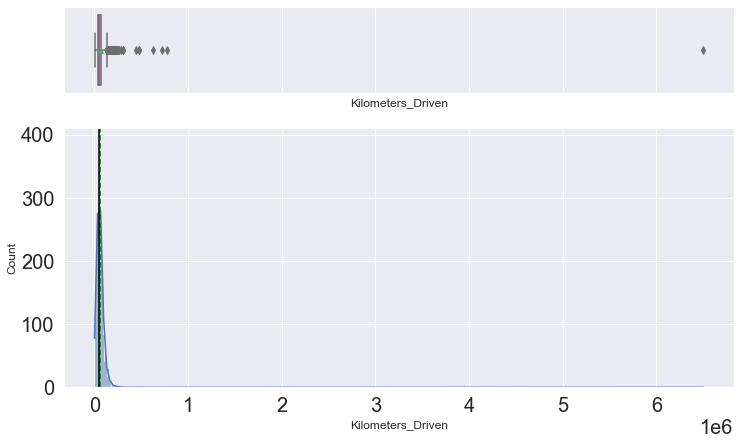

<IPython.core.display.Javascript object>

In [21]:
# Distribution of Kilometers_Driven
histogram_boxplot(df, "Kilometers_Driven", kde=True)

__Kilometers_Driven is heavily right skewed. <br/>
It will likely behave better on the log scale.__

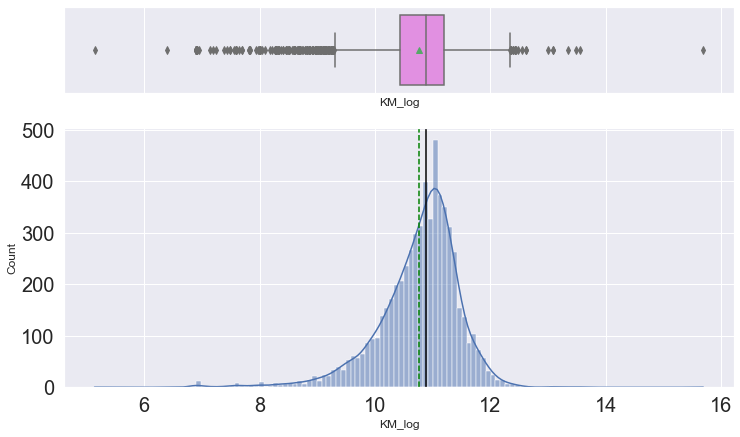

<IPython.core.display.Javascript object>

In [22]:
# add new column for log scalled Kilometers_Driven
df["KM_log"] = np.log(df["Kilometers_Driven"])
# Distribution of Kilometers_Driven on log scale
histogram_boxplot(df, "KM_log", kde=True)

In [23]:
# As KM_log distribution looks much better compared to Kilometers_Driven use log
df.drop("Kilometers_Driven", inplace=True, axis=1)

<IPython.core.display.Javascript object>

#### Mileage

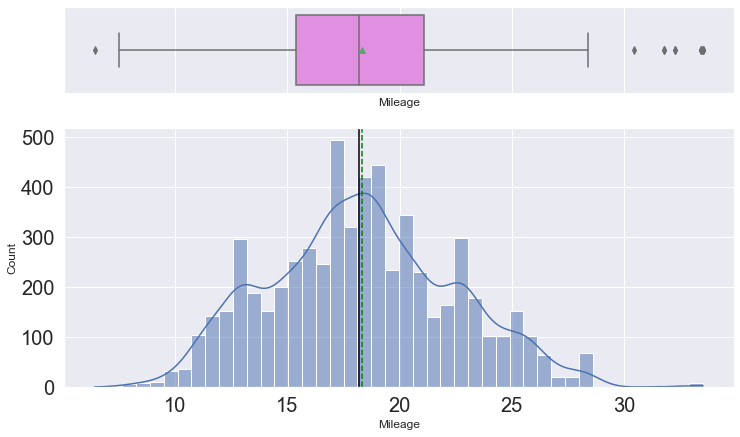

<IPython.core.display.Javascript object>

In [24]:
# Distribution of Mileage
histogram_boxplot(df, "Mileage", kde=True)

Mileage data looks normally distributed and may not need any treatment

#### Engine

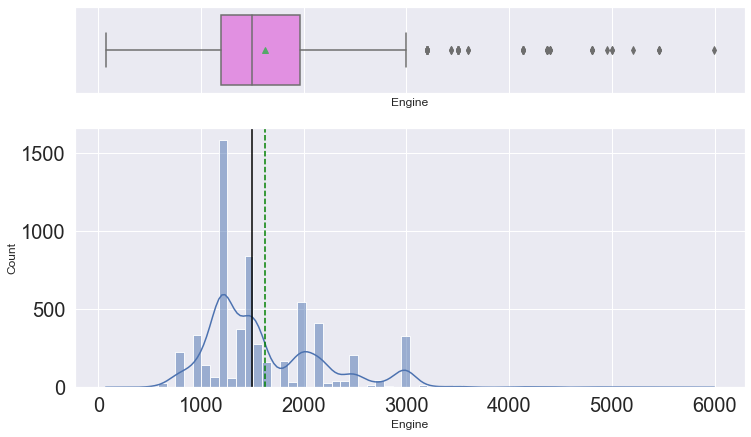

<IPython.core.display.Javascript object>

In [25]:
# Distribution of Engine
histogram_boxplot(df, "Engine", kde=True)

Engine Data as well looks right skewed and may be better on a log scale

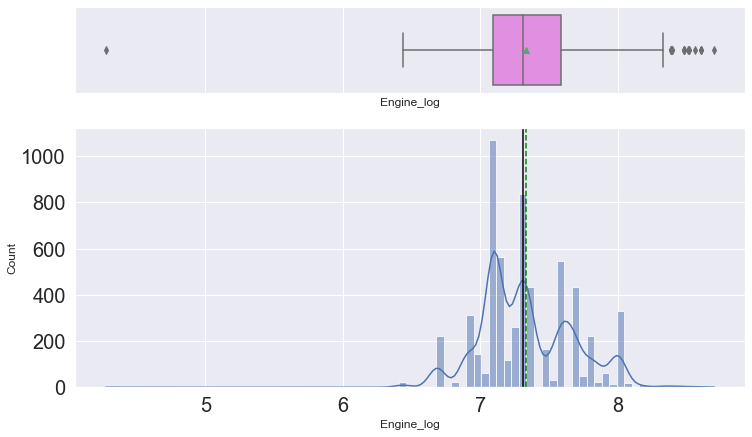

<IPython.core.display.Javascript object>

In [26]:
# add new column for log scalled Engine
df["Engine_log"] = np.log(df["Engine"])
# Distribution of Engine on log scale
histogram_boxplot(df, "Engine_log", kde=True)

 Looking at the Box-plot, there seems to be an Outlier causing a left skew<br/>
 We may need to take a decision if we want to keep this outlier or drop it<br/>
 
 Looking at the Engine values the min is too small. We may want to take a look at this value.<br/>
 It is noticed that there is only one value "72" less than 624.<br/>
 it will be better to treat this value same as missing.<br/>
 
 Looking at the max side there seem to be a few values above 5000 but these look to be correct for those models.<br/>
 We should not change the right side values for Engine.

In [27]:
df[df["Engine"] < 620]

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,KM_log,Engine_log
4446,Mahindra E Verito D4,Chennai,2016,Electric,Automatic,First,18.2,72.0,41.0,5.0,13.0,10.819778,4.276666


<IPython.core.display.Javascript object>

In [28]:
df[df["Engine"] > 5000]

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,KM_log,Engine_log
152,Mercedes-Benz S Class 2005 2013 S 500,Kolkata,2010,Petrol,Automatic,First,7.81,5461.0,362.9,5.0,30.0,10.470986,8.605387
4691,Mercedes-Benz Slk-Class 55 Amg,Bangalore,2014,Petrol,Automatic,Second,12.00,5461.0,421.0,2.0,90.0,8.006368,8.605387
4722,Mercedes-Benz Sl-Class Sl 500,Kolkata,2010,Petrol,Automatic,First,8.10,5461.0,387.3,2.0,29.5,10.463103,8.605387
5521,Bentley Continental Flying Spur,Hyderabad,2006,Petrol,Automatic,First,8.60,5998.0,552.0,4.0,59.0,10.778956,8.699181
5781,Lamborghini Gallardo Coupe,Delhi,2011,Petrol,Automatic,Third,6.40,5204.0,560.0,2.0,120.0,8.779557,8.557183


<IPython.core.display.Javascript object>

#### Engine distribution after Outlier treatment

In [29]:
# Treate the outlier same as missing
df["Engine"] = df["Engine"].replace(72, np.nan)
df["Engine"].fillna(col_median_by_name("Engine", df.Name), inplace=True)
df["Engine_log"] = np.log(df["Engine"])

<IPython.core.display.Javascript object>

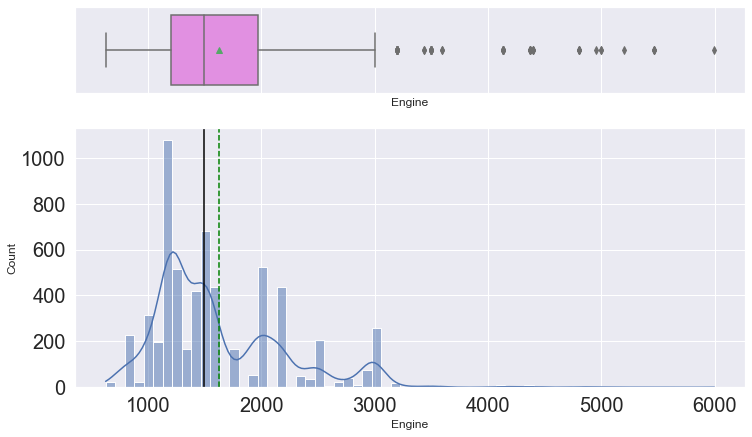

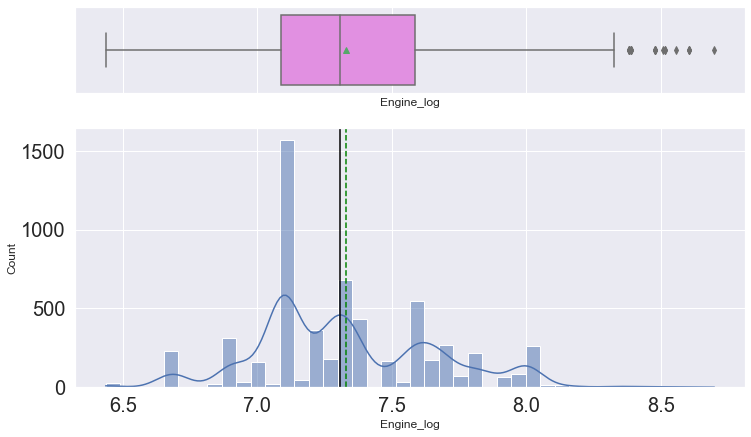

<IPython.core.display.Javascript object>

In [30]:
# Let's look at the distribution after removing the outlier
histogram_boxplot(df, "Engine", kde=True)
histogram_boxplot(df, "Engine_log", kde=True)

__After treating the outlier, the log scale distribution of the Engine values look good__<br>
We will keep the Engine_log column and drop the Engine column

In [31]:
# As Engine_log distribution looks much better compared to Engine use log
df.drop("Engine", inplace=True, axis=1)

<IPython.core.display.Javascript object>

### Power

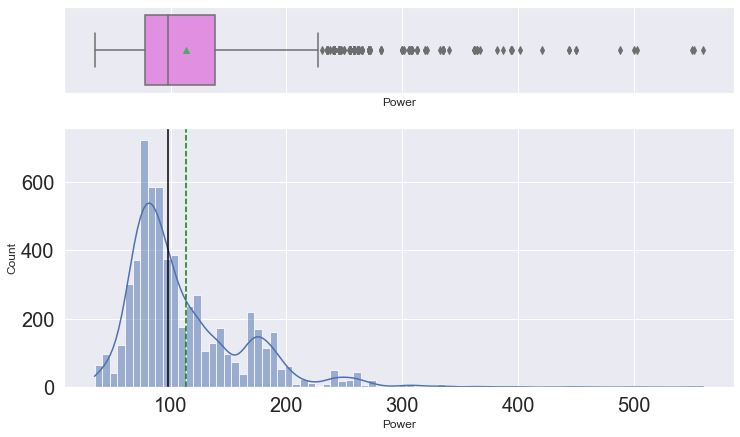

<IPython.core.display.Javascript object>

In [32]:
# Distribution of Power
histogram_boxplot(df, "Power", kde=True)

Power data too is right skewed.<BR/>
Let's see if log scale helps

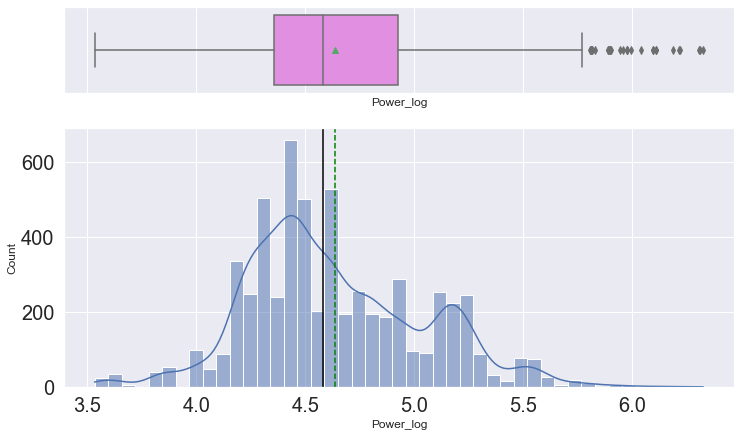

<IPython.core.display.Javascript object>

In [33]:
# add new Power_log column
df["Power_log"] = np.log(df["Power"])
# Distribution of Power on log scale
histogram_boxplot(df, "Power_log", kde=True)

__Log scale distribution of the Power data looks good.__<br/>
Keeping Power_log and dropping Power

In [34]:
# As Power_log distribution looks much better compared to Power, use log
df.drop("Power", inplace=True, axis=1)

<IPython.core.display.Javascript object>

In [35]:
# Lets take a look at the data
df.describe()

,Year,Mileage,Seats,Price,KM_log,Engine_log,Power_log
count,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,18.340598,5.277621,9.479468,10.758780,7.331230,4.636217
std,3.269742,4.151148,0.803479,11.187917,0.715788,0.336983,0.411565
min,1998.000000,6.400000,2.000000,0.440000,5.141664,6.436150,3.532226
25%,2011.000000,15.400000,5.000000,3.500000,10.434116,7.088409,4.356709
50%,2014.000000,18.200000,5.000000,5.640000,10.878047,7.308543,4.581902
75%,2016.000000,21.100000,5.000000,9.950000,11.198215,7.585281,4.927471
max,2019.000000,33.540000,10.000000,160.000000,15.687313,8.699181,6.327937


<IPython.core.display.Javascript object>

### Bivariate Analysis
Let look for any correlations between numeric columns

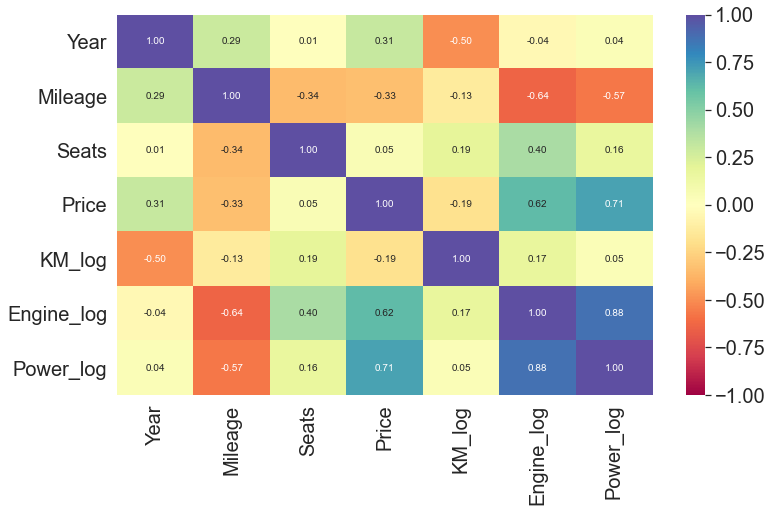

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observations
* Engine_log and Power_log columns are correlated but not enough for dropping one of them
* no other columns look much correlated

### Now let's take a look at the non-Numeric or categorical columns

In [37]:
df.describe(include="object")

,Name,Location,Fuel_Type,Transmission,Owner_Type
count,6019,6019,6019,6019,6019
unique,1852,11,5,2,4
top,Maruti Swift Dzire Vdi,Mumbai,Diesel,Manual,First
freq,50,790,3205,4299,4929


<IPython.core.display.Javascript object>

#### Observation: 
1. Except for Name, all the other columns have limited number of unique values
2. It maybe helpful to reduce Location column to some limited values like region
3. Fuel_Type, Transmission and Owner_Type columns should be replaced with dummies
4. Seats and Year column can also be replaced with dummies but it is worth checking if there is a possibility of reducing the number of unique values<br/>e.g. Can seats >= 7 can be grouped as large/Family vehicle?

### Location

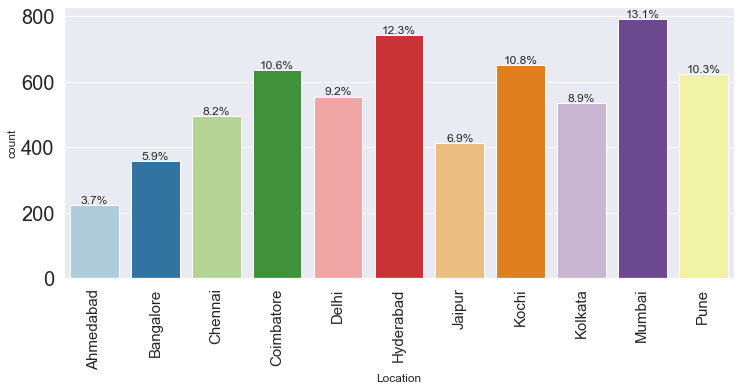

<IPython.core.display.Javascript object>

In [38]:
labeled_barplot(df, "Location", perc=True)

#### Location and Price relation

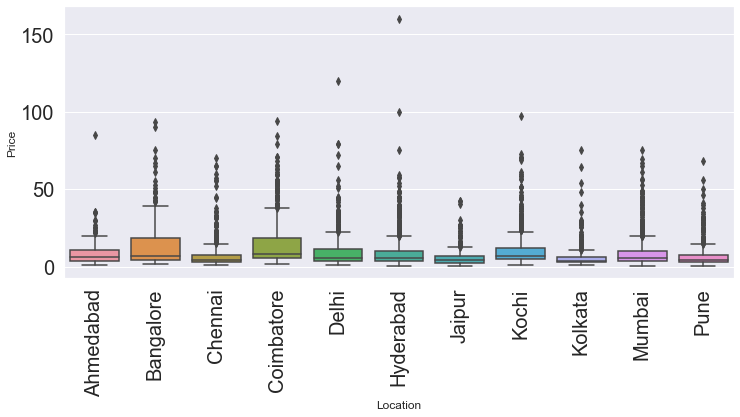

<IPython.core.display.Javascript object>

In [39]:
box_plot_by_cat(data=df, category_col="Location", y="Price")

Looking at the spread of the Location data, trying to group for regions may not help.<br/>
We will be replacing Location with dummies<br/>
Car Prices are comparatively higher in Coimbatore and Bangalore<br/>

### Seats

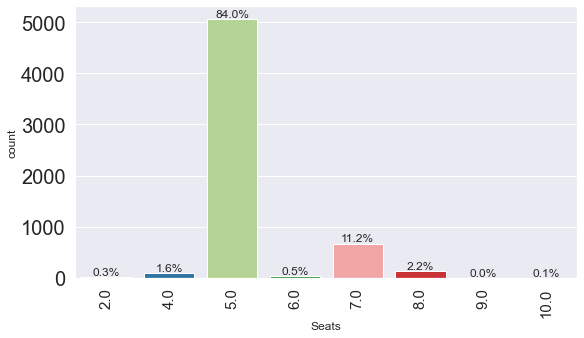

<IPython.core.display.Javascript object>

In [40]:
labeled_barplot(df, "Seats", perc=True)

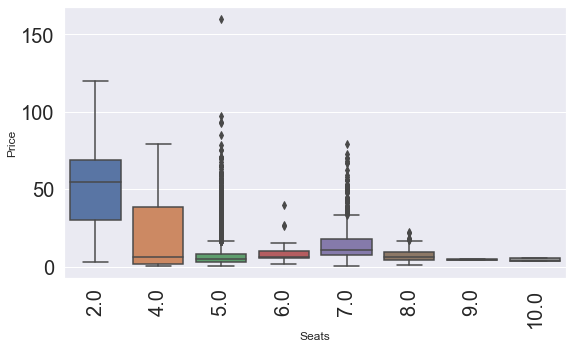

<IPython.core.display.Javascript object>

In [41]:
# Seats and Price Relation
box_plot_by_cat(data=df, category_col="Seats", y="Price")

84% cars are 5 seater. And 11.2% cars are 7 seater rest are very few<br/>
2 and 4 seater cars are expensive but only a few are sold.</br>
It it tempting to group all the cars other than 5 and 7 seats in one category but we may loose some important relation with price for 2, 4 and 6 seats<br/>
We will group all the cars more than 7 seats in one group.

In [42]:
df.loc[df.Seats > 7, "Seats"] = "Other"

<IPython.core.display.Javascript object>

#### Year

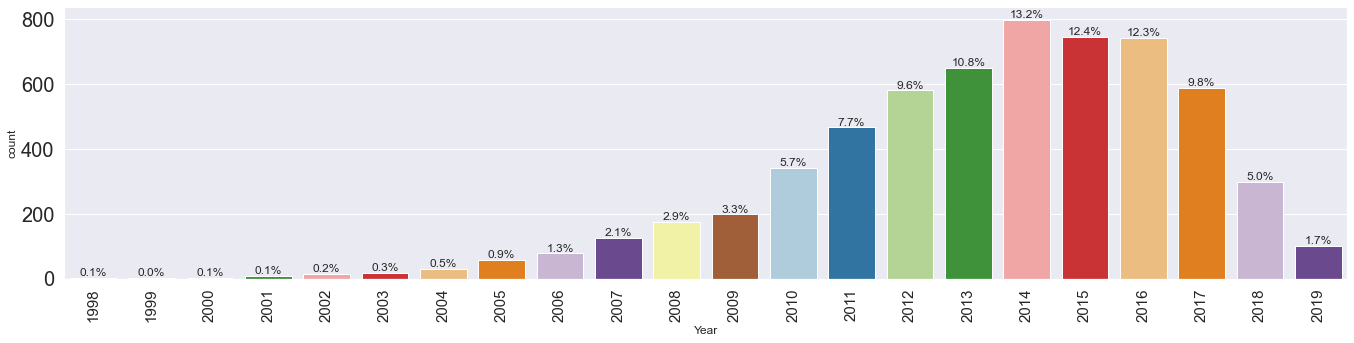

<IPython.core.display.Javascript object>

In [43]:
labeled_barplot(df, "Year", perc=True)

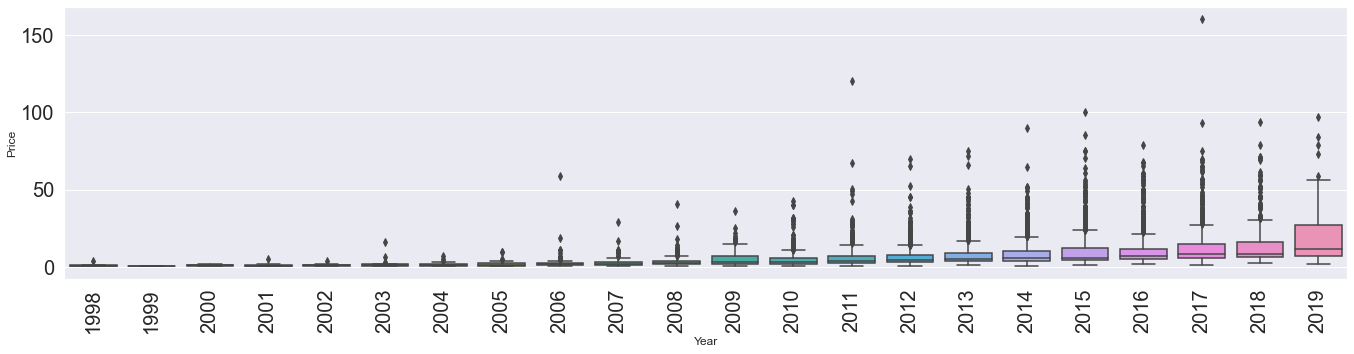

<IPython.core.display.Javascript object>

In [44]:
# Year and Price Relation
box_plot_by_cat(data=df, category_col="Year", y="Price")

Looking at the Year distribution, Very few cars older than 2011 are sold and their prices are low<br/>
Newer cars sell at a higher price.<br/>
__It will be interesting to see if Age of the car has a correlation with Price. And if so we may use Age and drop the year column.__

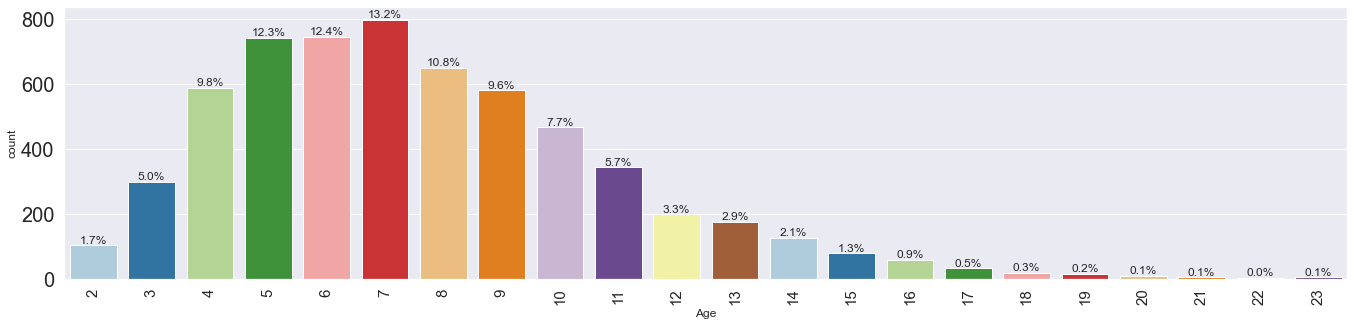

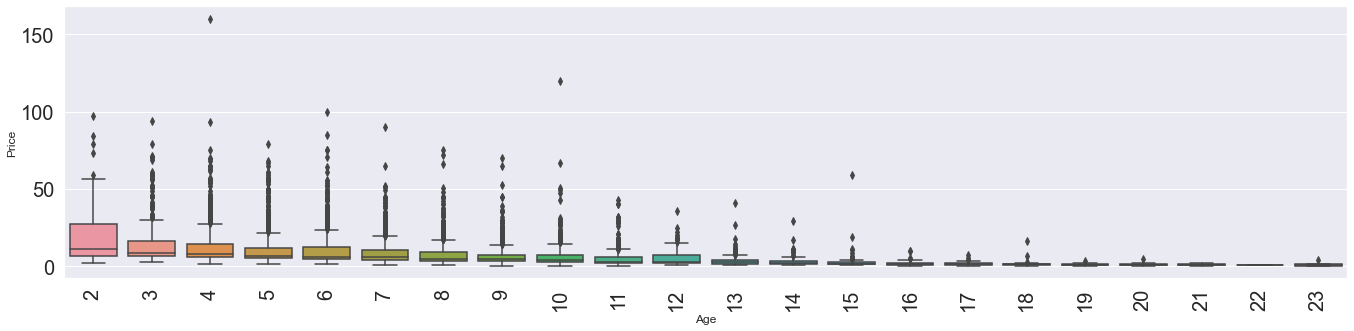

<IPython.core.display.Javascript object>

In [45]:
df["Age"] = 2021 - df["Year"]
# Age distribution
labeled_barplot(df, "Age", perc=True)
# Year and Price Relation
box_plot_by_cat(data=df, category_col="Age", y="Price")

* There is a decline in number for cars older than 11 years.
* There is a decline in price for cars older than 12 years.
* But we see a clear relation be age of the car and the Price.
* Age column looks a better choice over Year column.

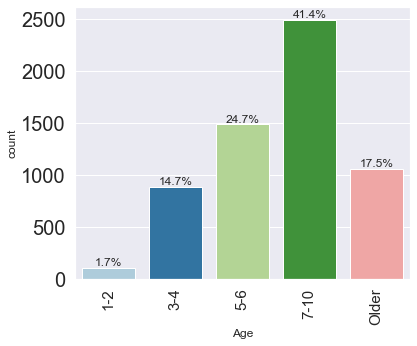

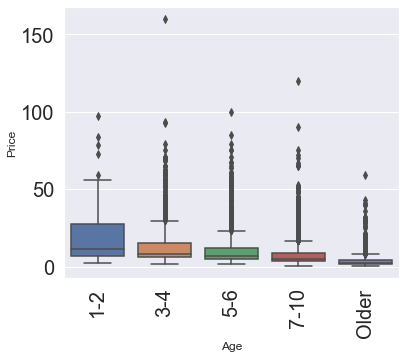

<IPython.core.display.Javascript object>

In [46]:
#  Lets create age groups and look again
age_groups = [2, 3, 5, 7, 11, 30]
age_labels = ["1-2", "3-4", "5-6", "7-10", "Older"]
df["Age"] = pd.cut(df.Age, age_groups, right=False, labels=age_labels)
# Age distribution
labeled_barplot(df, "Age", perc=True)
# Year and Price Relation
box_plot_by_cat(data=df, category_col="Age", y="Price")

Converting Year to Age-groups seems to reduce the number f categorical variables without missing out on any information. 

In [47]:
# Drop Year
df.drop("Year", inplace=True, axis=1)

<IPython.core.display.Javascript object>

### How about Names? Too many?
It may be a good idea to take a look at the names and see if some cleanup can reduce the total number of names.<br/>
It will also be helpful to see if we can extract some other features from the name. e.g. Brand

In [48]:
# Ensure Name does not have leading and trailing spaces. And are in Title case.
df["Name"] = df.Name.str.strip().str.title()
# Split the Name column into Make and Model
df[["Make", "Model"]] = df.Name.str.split(n=1, expand=True)
df["Make"].describe()

count       6019
unique        30
top       Maruti
freq        1211
Name: Make, dtype: object

<IPython.core.display.Javascript object>

* There are 30 Unique Makes
* "Land Rover" is selected as "Land" and "Mini Cooper" is selected as "Mini". This needs to be fixed.

In [49]:
# lets fix the Makes and Model names
df["Make"] = df.Make.replace({"Land": "Land Rover", "Mini": "Mini Cooper"})
df["Model"] = df.Model.str.replace("Rover", "").str.replace("Cooper", "").str.strip()

# Split the Model column into Base_Model and Sub_Model
df[["Base_Model", "Sub_Model"]] = df.Model.str.split(n=1, expand=True)
# Combine Make and Base_Model to get the Model column
df["Model"] = df[["Make", "Base_Model"]].agg("_".join, axis=1)
# then drop the Make, Base_Model and Sub_Model
df.drop(["Make", "Base_Model", "Sub_Model"], inplace=True, axis=1)
df["Model"].describe()

count             6019
unique             220
top       Maruti_Swift
freq               353
Name: Model, dtype: object

<IPython.core.display.Javascript object>

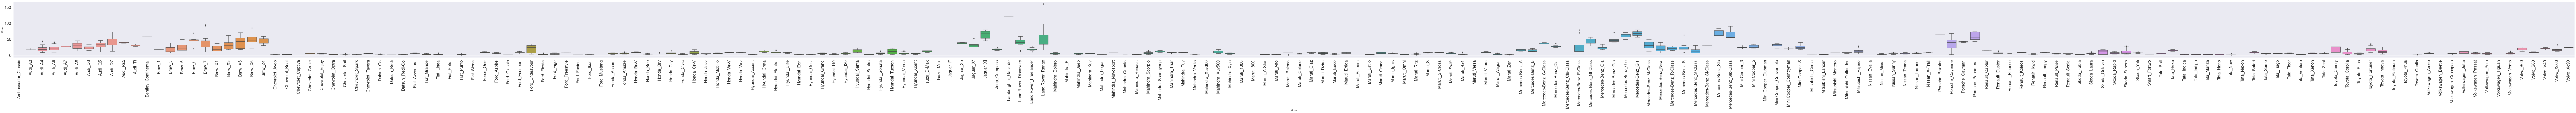

<IPython.core.display.Javascript object>

In [50]:
box_plot_by_cat(data=df, category_col="Model", y="Price")

__The common knowledge that cars can be grouped "Entry_level", "Mid_level" and "Luxury" based on the model Price is clearly visible in the above chart.__<br/>
Lets group the modes into 5 categories based on the median Price for each model

In [51]:
# Create a new datftame to calculate the categories nased on Median Model Price
model_df = df[["Model", "Price"]].groupby(by="Model").median()
# Create Model Categores
model_df["Category"] = pd.cut(
    model_df["Price"],
    bins=[-np.inf, 5.0, 10.0, 30.0, 50.0, np.inf],
    labels=["Entry_Level", "Mid_Range", "Premium", "Luxury", "Ultra_Luxury"],
)

# Drop the Price column.
model_df.drop("Price", inplace=True, axis=1)
model_df.groupby(by="Category").count()
model_df.loc["Maruti_Swift"]["Category"]

'Entry_Level'

<IPython.core.display.Javascript object>

In [52]:
# function to get category for model
def get_category(model):
    return model_df.loc[model]["Category"]


# Add the Category column to the main Dataframe
df["Category"] = df["Model"].apply(get_category)
# Drop the Model and Name column as it is not needed anymore
df.drop(["Model", "Name"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [53]:
df.describe()

,Mileage,Price,KM_log,Engine_log,Power_log
count,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,18.340598,9.479468,10.758780,7.331230,4.636217
std,4.151148,11.187917,0.715788,0.336983,0.411565
min,6.400000,0.440000,5.141664,6.436150,3.532226
25%,15.400000,3.500000,10.434116,7.088409,4.356709
50%,18.200000,5.640000,10.878047,7.308543,4.581902
75%,21.100000,9.950000,11.198215,7.585281,4.927471
max,33.540000,160.000000,15.687313,8.699181,6.327937


<IPython.core.display.Javascript object>

In [54]:
df.describe(include=["object", "category"])

,Location,Fuel_Type,Transmission,Owner_Type,Seats,Age,Category
count,6019,6019,6019,6019,6019.0,6019,6019
unique,11,5,2,4,6.0,5,5
top,Mumbai,Diesel,Manual,First,5.0,7-10,Entry_Level
freq,790,3205,4299,4929,5057.0,2492,2719


<IPython.core.display.Javascript object>

#### Create Dummies
Lets replace the Category columns with the dummies

In [55]:
df = pd.get_dummies(
    df,
    columns=[
        "Fuel_Type",
        "Transmission",
        "Owner_Type",
        "Location",
        "Seats",
        "Age",
        "Category",
    ],
    prefix=["", "", "Owner_", "", "Seats-", "Age_", ""],
    prefix_sep="",
    drop_first=True,
)
df.shape

(6019, 36)

<IPython.core.display.Javascript object>

In [56]:
df.sample(10)

,Mileage,Price,KM_log,Engine_log,Power_log,Diesel,Electric,LPG,Petrol,Manual,Owner_Fourth & Above,Owner_Second,Owner_Third,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune,Seats-4.0,Seats-5.0,Seats-6.0,Seats-7.0,Seats-Other,Age_3-4,Age_5-6,Age_7-10,Age_Older,Luxury,Mid_Range,Premium,Ultra_Luxury
5036,13.06,4.25,11.174652,7.376508,4.630155,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1196,22.74,2.10,10.373491,6.679599,3.856510,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4339,16.50,5.25,10.373491,7.088409,4.463607,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1578,13.60,7.00,10.463103,7.833204,4.581902,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2502,11.10,5.25,11.385092,7.763871,4.955827,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
5488,16.55,8.50,10.736397,7.584773,4.993896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
3148,16.36,25.70,9.798127,7.686621,5.234845,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3157,25.40,1.60,9.729729,6.436150,3.624341,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2697,17.00,1.00,11.982929,7.247793,4.248495,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
5639,16.47,2.95,10.085809,7.088409,4.302713,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


<IPython.core.display.Javascript object>

## Model Building
Now that we have cleaned up the data, let's get started on building the model

### Separate out the Dependent Variable

In [57]:
# Price is our dependent variable
x = df.drop("Price", axis=1)
y = df["Price"]

<IPython.core.display.Javascript object>

### Split the data into Train and Test sets

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

<IPython.core.display.Javascript object>

In [59]:
print(f"Number of rows in train data = {x_train.shape[0]}")
print(f"Number of rows in test data = {x_test.shape[0]}")

Number of rows in train data = 4213
Number of rows in test data = 1806


<IPython.core.display.Javascript object>

### Let's fit the model

In [60]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [61]:
# Lets take alook at the Coef and intercepts
coef_df = pd.DataFrame(
    np.append(lr_model.coef_, lr_model.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

,Coefficients
Mileage,-0.027494
KM_log,-1.575810
Engine_log,0.107364
Power_log,7.596020
Diesel,-0.106599
Electric,1.159367
LPG,-0.036912
Petrol,-1.915539
Manual,-1.857832
Owner_Fourth & Above,-1.862235


<IPython.core.display.Javascript object>

### Interpretation of Coefficients 
* Coefficients for Car Categories are a lot higher compared to other variables
* Coefficients for Seats look highest on the -ve side
* In Fuel_Types only Electric has a +ve coefficient
* Some cities have a +ve coefficient while others have -ve
* Age of the car also has -ve coefficients

## Model Performance check
We will be using the predefined functions for RMSE, MAE, and 𝑅2.

In [62]:
# Checking model performance on train set
print("Training Performance\n")
lr_model_train_perf = model_performance_regression(lr_model, x_train, y_train)
lr_model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.94215,2.767216,0.808983,0.807382,47.233627


<IPython.core.display.Javascript object>

In [63]:
# Checking model performance on test set
print("Test Performance\n")
lr_model_test_perf = model_performance_regression(lr_model, x_test, y_test)
lr_model_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.71354,2.757163,0.812912,0.809213,46.249271


<IPython.core.display.Javascript object>

### Observations
* The $R^2$ values for both Train and Test sets are 0.81. Meaning they explain 81% of the total variation in the train and test sets.
* RMSE on the test set is slightly lower than on the train set. This confirms that the Model is not overfitting.
* MAE indicates that our current model is able to predict Price within a mean error of 2.76 on the test set.
* MAPE of 46.25 on the test data means that we are able to predict within 46.25% of the Price.

## Forward Feature Selection
Let us try to reduce the number of features and pick the important ones using Forward Feature Selection

In [64]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


reg = LinearRegression()

# Build step forward feature selection
sfs = SFS(
    reg,
    k_features=x_train.shape[1],
    forward=True,  # k_features denotes "Number of features to select"
    floating=False,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    cv=5,
)

# Perform SFFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.1s finished

[2021-10-16 00:26:19] Features: 1/35 -- score: 0.48111679184054756[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.1s finished

[2021-10-16 00:26:19] Features: 2/35 -- score: 0.5641593760823211[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.1s finished

[2021-10-16 00:26:20] Features: 3/35 -- score: 0.663078687591612[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of

<IPython.core.display.Javascript object>

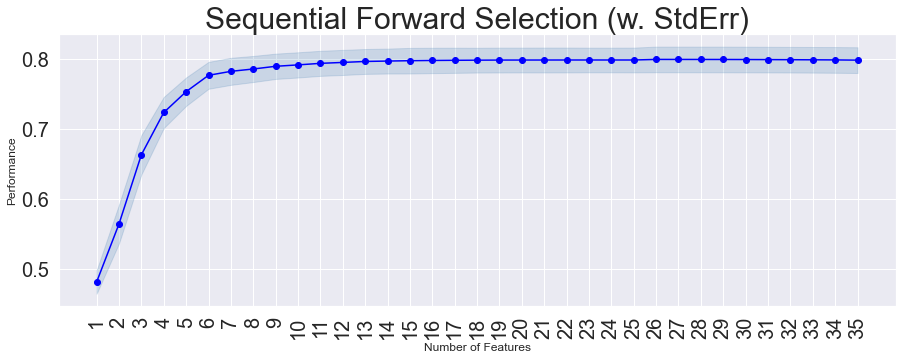

<IPython.core.display.Javascript object>

In [65]:
# to plot the performance with addition of each feature
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=(15, 5))
plt.title("Sequential Forward Selection (w. StdErr)")
plt.xticks(rotation=90)
plt.show()

### Observation
* After 13 features there is no change in the performance of the model with any new added feature 

In [66]:
reg = LinearRegression()

# # Build step forward feature selection
sfs = SFS(
    reg,
    k_features=13,
    forward=True,
    floating=False,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    cv=5,
)

# Perform SFFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished

[2021-10-16 00:26:23] Features: 1/13 -- score: 0.48111679184054756[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.1s finished

[2021-10-16 00:26:23] Features: 2/13 -- score: 0.5641593760823211[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.1s finished

[2021-10-16 00:26:23] Features: 3/13 -- score: 0.663078687591612[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of

<IPython.core.display.Javascript object>

In [67]:
# Let us select features which are important
feat_cols = list(sfs.k_feature_idx_)
print(feat_cols)

[1, 3, 7, 8, 12, 14, 16, 28, 29, 30, 31, 33, 34]


<IPython.core.display.Javascript object>

In [68]:
x_train.columns[feat_cols]

Index(['KM_log', 'Power_log', 'Petrol', 'Manual', 'Bangalore', 'Coimbatore',
       'Hyderabad', 'Age_5-6', 'Age_7-10', 'Age_Older', 'Luxury', 'Premium',
       'Ultra_Luxury'],
      dtype='object')

<IPython.core.display.Javascript object>

### Lets now fit the model using the top features identified above

In [69]:
# Creating new x_train and x_test with the the top 13 features
x_train_2 = x_train[x_train.columns[feat_cols]]
x_test_2 = x_test[x_train_2.columns]

<IPython.core.display.Javascript object>

In [70]:
lr_model2 = LinearRegression()
lr_model2.fit(x_train_2, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [71]:
# Lets take alook at the Coef and intercepts
coef_df2 = pd.DataFrame(
    np.append(lr_model2.coef_, lr_model2.intercept_),
    index=x_train_2.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df2

,Coefficients
KM_log,-1.489161
Power_log,7.015758
Petrol,-1.566513
Manual,-2.042531
Bangalore,1.819707
Coimbatore,1.781785
Hyderabad,1.861657
Age_5-6,-1.500272
Age_7-10,-3.815168
Age_Older,-6.166102


<IPython.core.display.Javascript object>

In [72]:
# Checking model performance on train set
print("Training Performance\n")
lr_model2_train_perf = model_performance_regression(lr_model2, x_train_2, y_train)
lr_model2_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,5.001587,2.788883,0.80436,0.803755,47.727395


<IPython.core.display.Javascript object>

In [73]:
# Checking model performance on test set
print("Test Performance\n")
lr_model2_test_perf = model_performance_regression(lr_model2, x_test_2, y_test)
lr_model2_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.807216,2.785093,0.805402,0.80399,46.48661


<IPython.core.display.Javascript object>

### Lets now compare the performances between the sklearn  and SFS features models

In [74]:
# performance comparison

models_train_comp_df = pd.concat(
    [
        lr_model_train_perf.T,
        lr_model2_train_perf.T,
        lr_model_test_perf.T,
        lr_model2_test_perf.T,
    ],
    axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression sklearn - Train",
    "Linear Regression sklearn (SFS features) - Train",
    "Linear Regression sklearn - Test",
    "Linear Regression sklearn (SFS features) - Test",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Linear Regression sklearn - Train,Linear Regression sklearn (SFS features) - Train,Linear Regression sklearn - Test,Linear Regression sklearn (SFS features) - Test
RMSE,4.942150,5.001587,4.713540,4.807216
MAE,2.767216,2.788883,2.757163,2.785093
R-squared,0.808983,0.804360,0.812912,0.805402
Adj. R-squared,0.807382,0.803755,0.809213,0.803990
MAPE,47.233627,47.727395,46.249271,46.486610


<IPython.core.display.Javascript object>

### Observations
* Using SFS features has the same performance (slightly improved) over the sklearn model
* SFS features model uses less than half the features (13 out of 35)
* SFS features model is a better choice over sklearn model

## Lets try adding interaction terms

In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# create PolynomialFeatures of degree 2 and include only interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True)
# create transformations and add new columns to train and test data
x_train_poly = poly.fit_transform(x_train_2)
x_test_poly = poly.fit_transform(x_test_2)

# Build a new linear regression model with the new data including the interaction terms
poly_clf = linear_model.LinearRegression()
poly_clf.fit(x_train_poly, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [76]:
# Checking model performance on train set
print("Train Performance\n")
poly_clf_model_train_perf = model_performance_regression(
    poly_clf, x_train_poly, y_train
)
poly_clf_model_train_perf

Train Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.821725,2.000714,0.885775,0.883225,28.51018


<IPython.core.display.Javascript object>

In [77]:
# Checking model performance on test set
print("Test Performance\n")
poly_clf_model_test_perf = model_performance_regression(poly_clf, x_test_poly, y_test)
poly_clf_model_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.881116,2.036176,0.873158,0.866345,26.882921


<IPython.core.display.Javascript object>

In [78]:
# performance comparison

models_train_comp_df = pd.concat(
    [
        poly_clf_model_train_perf.T,
        lr_model2_train_perf.T,
        poly_clf_model_test_perf.T,
        lr_model2_test_perf.T,
    ],
    axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression Poly - Train",
    "Linear Regression sklearn (SFS features) - Train",
    "Linear Regression Poly - Test",
    "Linear Regression sklearn (SFS features) - Test",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Linear Regression Poly - Train,Linear Regression sklearn (SFS features) - Train,Linear Regression Poly - Test,Linear Regression sklearn (SFS features) - Test
RMSE,3.821725,5.001587,3.881116,4.807216
MAE,2.000714,2.788883,2.036176,2.785093
R-squared,0.885775,0.804360,0.873158,0.805402
Adj. R-squared,0.883225,0.803755,0.866345,0.803990
MAPE,28.510180,47.727395,26.882921,46.486610


<IPython.core.display.Javascript object>

### Observations
* Adding interaction terms has improved the model performance
* This improved performance comes with a cost of added complexity to the model

## Conclusion

* We have developed a model ___(poly_clf)___ for predicting the price of a used car.
* This model is able to predict the the price within a mean error of 2.04 on test data